# Data 201

Data Wrangling, S2 2021

## Assignment 2: 
## Ada Mohd Izhair (75733329) & Zhenyuan He (11969443)

>## Scraping data from Trustpilot
>
>In this assignment we attempt to do web scraping on a review website called 'Trustpilot'.
>Trustpilot is a platform that hosts reviews from consumers, so that other consumers can utilise the information 
>from this site to make choices and judgements.
>
>We plan to extract the company/business name, the number of reviews made for the specific company, the rating, what sub-category this company belongs to,
>and also give evaluation as to what tier the company would belong using our own methodology. 

In [1]:
library(tidyverse)
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr) # to hand strings

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [3]:
library(rvest) # rvest makes scraping easier
library(polite) # polite is the "polite" version of rvest
library(xml2) # makes it easier to work with HTML and XML from R


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




### Task (a): scrape it (5 marks)


In [4]:
one_link <- "https://nz.trustpilot.com/review/flashbay.co.nz"
page_one_link <- one_link %>% read_html()

>Variable "one_link" stores the link to one page of the Electronics category, "Flashbay".
>
>Variable "page_one_link" converts the link to html format, as proven in tests following.

In [5]:
page_one_link %>% typeof()
page_one_link %>% glimpse()

[1] "list"

List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"


In [105]:
page_one_link

{html_document}
<html lang="en-nz">
[1] <head>\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8 ...
[2] <body>\n        \n<header class="header header--fixed" data-header role=" ...

In [106]:
page_one_link %>% html_structure()

>Below, we create selectors for each data we want to scrape from the page.

In [6]:
company_name_selector <- 'body > main > div > div.placeholder > div > div.company-profile-header > section.company-summary > div > div.right-section > section > h1 > span.multi-size-header__big'
review_count_selector <- 'body > main > div > div.company-profile-body > section > div.reviews-overview > div.card.card--related > div.reviews-overview-header > h2 > span'
rating_selector <- 'body > main > div > div.placeholder > div > div.company-profile-header > section.company-summary > div > div.right-section > div > div.trustscore_container > p'
category_selector <- 'body > main > div > div.placeholder > div > div.company-profile-header > section.company-summary > div > div.right-section > p > a'

company_name <- page_one_link %>% 
    html_elements(company_name_selector) %>% html_text

review_count <- page_one_link %>% 
    html_elements(review_count_selector) %>% html_text

company_rating <- page_one_link %>% 
    html_elements(rating_selector) %>% html_text

company_category <- page_one_link %>% 
    html_elements(category_selector) %>% html_text

company_name
review_count
company_rating
company_category

[1] "\n                        Flashbay\n                    "

[1] "1,192"

[1] "5.0"

[1] "Drives and Storage Service"

>Tests above show that each selector works as intended, although the data extracted is slightly messy.
>
>We then use these selectors to build up functions to extract each element on the page:

In [7]:
# Individual get functions for each category

get_company_name <- function(page_one_link){
    company_name <- page_one_link %>%
             html_elements(company_name_selector) %>%
             html_text
    return(company_name)
}

get_review_count <- function(page_one_link){
    review_count <- page_one_link %>%
             html_elements(review_count_selector) %>%
             html_text
    return(review_count)
}

get_company_rating <- function(page_one_link){
    company_rating <- page_one_link %>%
             html_elements(rating_selector) %>%
             html_text
    return(company_rating)
}

get_sub_category <- function(page_one_link){
    company_category <- page_one_link %>%
             html_elements(category_selector) %>%
             html_text
    return(company_category)
}


>For efficiency, these can be combined into one whole function to extract all the necessary information on one page within one function
    >and store all information in a newly created dataframe:

In [8]:
# Functions combined into one, create a dataframe.

get_company_deets <- function(link){
    
    page <- link %>% read_html()
    
    company <- page %>% html_elements(company_name_selector) %>% html_text
    review_count <- page %>% html_elements(review_count_selector) %>% html_text
    rating <- page %>% html_elements(rating_selector) %>% html_text
    category <- page %>% html_elements(category_selector) %>% html_text
    
    tp_category_df <- tibble(Company = company, Reviews = review_count, Rating = rating, Category = category)
    return(tp_category_df)
}

# Testing that the above function works:

get_company_deets(one_link)

Company,Reviews,Rating,Category
<chr>,<chr>,<chr>,<chr>
Flashbay,"1,192",5.0,Drives and Storage Service


>This function allows us to extract the information on one company on one page link.

### Task (b): wrangle it (5 marks)


In [9]:
tp_category_df <- get_company_deets(one_link)
tp_category_df %>% glimpse()

Rows: 1
Columns: 4
$ Company  <chr> "\n                        Flashbay\n                    "
$ Reviews  <chr> "1,192"
$ Rating   <chr> "5.0"
$ Category <chr> "Drives and Storage Service"



    
> **Findings and Comments on current dataframe**
>
>As seen above, the dataframe currently consists of 4 columns: Company, Reviews, Rating, and Category.
Evident problems in the scraped data put into this dataframe are:
>
>- Company name contains unnecessary lines and spaces
>- Reviews is of string form with ',' formatting therefore this will be hard to work on unless converted to integer.
>- Rating is of string form, needs to be converted to integer for further investigation.

In [10]:
tp_category_df %<>%
    mutate(Company = Company %>% str_squish(),
           Reviews = Reviews %>% str_remove_all('[,]') %>% as.integer(),
           Rating = Rating %>% as.double())

tp_category_df %>% glimpse()

Rows: 1
Columns: 4
$ Company  <chr> "Flashbay"
$ Reviews  <int> 1192
$ Rating   <dbl> 5
$ Category <chr> "Drives and Storage Service"





> **Explanation on changes to dataframe**
>
>Changes done in dataframe that account for problems stated earlier:
>
>- Use of str_squish() to remove unnecessary lines and spaces. 
>- Any ',' characters in the Reviews string are removed, then converted to integer values.
>- Rating is now of integer form.
>

> **Creating a new column in dataframe**
>
>Implement a Tier column to categorize the companies into different tiers according to their rating scores:

In [11]:
tp_category_df %<>%
    mutate(Tier = case_when(4 < Rating & Rating <= 5 ~ "Excellent", 
                            3 < Rating & Rating <= 4 ~ "Great", 
                            2 < Rating & Rating <= 3 ~ "Average", 
                            1 < Rating & Rating <= 2 ~ "Poor", 
                            TRUE ~ "Bad"))


In [12]:
tp_category_df # Testing to see the new column

Company,Reviews,Rating,Category,Tier
<chr>,<int>,<dbl>,<chr>,<chr>
Flashbay,1192,5,Drives and Storage Service,Excellent


>We can see a newly added column of Tiers, this is to see how many companies are categorized in different Tiers.
>
>**Combining all into one function to generate a dataframe**:

In [13]:
# Create a generate df function

generate_tp_category_df <- function(one_link){
    tp_category_df <- get_company_deets(one_link)
    
    tp_category_df %>%
    mutate(Company = Company %>% str_squish(),
           Reviews = Reviews %>% str_remove_all('[,]') %>% as.integer(),
           Rating = Rating %>% as.double(), 
           Tier = case_when(4.5 < Rating & Rating <= 5 ~ "Excellent", 
                            3 < Rating & Rating <= 4.5 ~ "Great", 
                            2 < Rating & Rating <= 3 ~ "Average", 
                            1 < Rating & Rating <= 2 ~ "Poor", 
                            TRUE ~ "Bad")) 
}

generate_tp_category_df(one_link) # Testing that the function works as expected

Company,Reviews,Rating,Category,Tier
<chr>,<int>,<dbl>,<chr>,<chr>
Flashbay,1192,5,Drives and Storage Service,Excellent


### Task (c): automate it (5 marks)


>Attempting to automate the scraping process across different companies on the site.
>
>Beginning with collecting list of urls

In [14]:
web <- "https://nz.trustpilot.com/categories/electronics_technology"
websites <- web %>% read_html() %>% html_nodes(".styles_businessUnitCardsContainer__1ggaO")
all_web <- websites %>% html_nodes("a") %>% html_attrs() %>% map_chr("href")
linklist <- tibble(all_web)

linklist # Testing to see if links are gathered correctly

all_web
<chr>
/review/flashbay.co.nz
/review/www.avstore.co.nz
/review/www.mightyape.co.nz
/review/portableappliancetesters.co.nz
/review/equipo.co.nz
/review/onlydomains.com
/review/supero.co.nz
/review/www.luminpdf.com
/review/thunderstore.nz


>Generating a holder dataframe to be used to store values:

In [155]:
# Holder dataframe with empty rows 
tp_df_holder <- tibble(Company=character(), Reviews=integer(), Rating=integer(), Category=character(), Tier=character(), .rows = NULL)
tp_df_holder 

Company,Reviews,Rating,Category,Tier
<chr>,<int>,<int>,<chr>,<chr>


>We then automate through each company link in all_web to extract the information and store these values into the holder dataframe:

In [156]:
for (link in all_web){
    url <- glue('https://nz.trustpilot.com/{link}')
    temp <- generate_tp_category_df(url) 
    tp_df_holder %<>% 
    add_row(temp[1,])
}

In [157]:
tp_df_holder # Checking that the above works

Company,Reviews,Rating,Category,Tier
<chr>,<int>,<dbl>,<chr>,<chr>
Flashbay,1192,5.0,Drives and Storage Service,Excellent
Avstore,235,4.9,Audio Visual Equipment Supplier,Excellent
Mighty Ape,3080,4.9,Gaming service Provider,Excellent
Appliance Testing Supplies,133,4.8,Electronics Company,Excellent
Equipo.co.nz,69,4.8,Watch Store,Excellent
OnlyDomains,1887,4.7,e-Commerce Service,Excellent
Supero,638,4.6,Electronics Store,Excellent
Lumin PDF,192,4.5,Software Company,Great
Thunder Store,37,4.5,Computer Store,Great


>We can see that values from each of the links in variable "all_web" are now stored in the tp_df_holder dataframe, and that the function works perfectly.
>
>**Creating a function that combines all the above so that all company information for one category type can be scraped and put into the dataframe:**

In [158]:
auto1 <- function(type) {
    web <- glue("https://nz.trustpilot.com/categories/{type}")

    websites <- web %>% read_html() %>% html_nodes(".styles_businessUnitCardsContainer__1ggaO")
    all_web <- websites %>% html_nodes("a") %>% html_attrs() %>% map_chr("href") # Generate list of links
    
    tp_df_holder <- tibble(Company=character(), Reviews=integer(), Rating=integer(), Category=character(), Tier=character(), .rows = NULL)
    
    for (link in all_web){
        url <- glue('https://nz.trustpilot.com/{link}')
        temp <- generate_tp_category_df(url)
        tp_df_holder %<>% 
        add_row(temp[1,])
    }
    tp_df_holder <- tp_df_holder %>% mutate(Type = type)
    return(tp_df_holder)
}

In [160]:
web_name <- c("electronics_technology", "education_training", 
             "health_medical", "business_services", 
              "travel_vacation",  "restaurants_bars",
              "sports")
web_name

[1] "electronics_technology" "education_training"     "health_medical"        
[4] "business_services"      "travel_vacation"        "restaurants_bars"      
[7] "sports"

In [161]:
table1 <- map_df(web_name, auto1)

In [174]:
table1 %<>% na.omit()
table1

Company,Reviews,Rating,Category,Tier,Type
<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
Flashbay,1192,5.0,Drives and Storage Service,Excellent,electronics_technology
Avstore,235,4.9,Audio Visual Equipment Supplier,Excellent,electronics_technology
Mighty Ape,3080,4.9,Gaming service Provider,Excellent,electronics_technology
Appliance Testing Supplies,133,4.8,Electronics Company,Excellent,electronics_technology
Equipo.co.nz,69,4.8,Watch Store,Excellent,electronics_technology
OnlyDomains,1887,4.7,e-Commerce Service,Excellent,electronics_technology
Supero,638,4.6,Electronics Store,Excellent,electronics_technology
Lumin PDF,192,4.5,Software Company,Great,electronics_technology
Thunder Store,37,4.5,Computer Store,Great,electronics_technology


### Task (d): plot it (2 marks)

>**Investigating the relationship between the number of reviews and the rating given**
>
>We want to investigate if the number of reviews a company gets/its popularity affects the rating the company would receive from consumers. 
>Would a more used, more well-known company (shown by number of reviews) be more prone to harsher, poorer reviews or vice versa?

>Are high rated companies the most reviewed or not?

`geom_smooth()` using formula 'y ~ x'



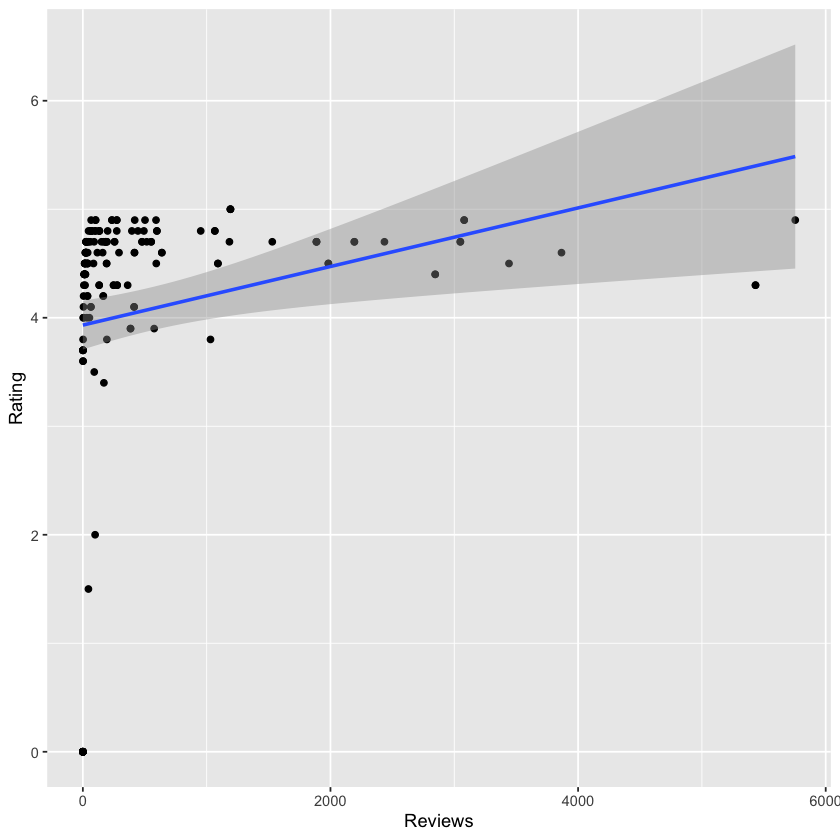

In [175]:
ggplot(table1, 
       aes(x = Reviews , y =  Rating)) + geom_point() + geom_smooth(method = "lm")


>From this ggplot, there is evidently some outliers outside the trend band, clear ones being companies with ratings of below 2.
>Companies below 2.0 ratings have a lot less reviews which may be a factor into why these companies have such low ratings.
>The majority of the dataset have approximately 500 ratings, and these ratings are values pretty highly as they all fall under above average to excellent
according to the tier system we implemented (3-5 ratings).
>
>To investigate further we will remove these extreme outliers to get better insight:

`geom_smooth()` using formula 'y ~ x'



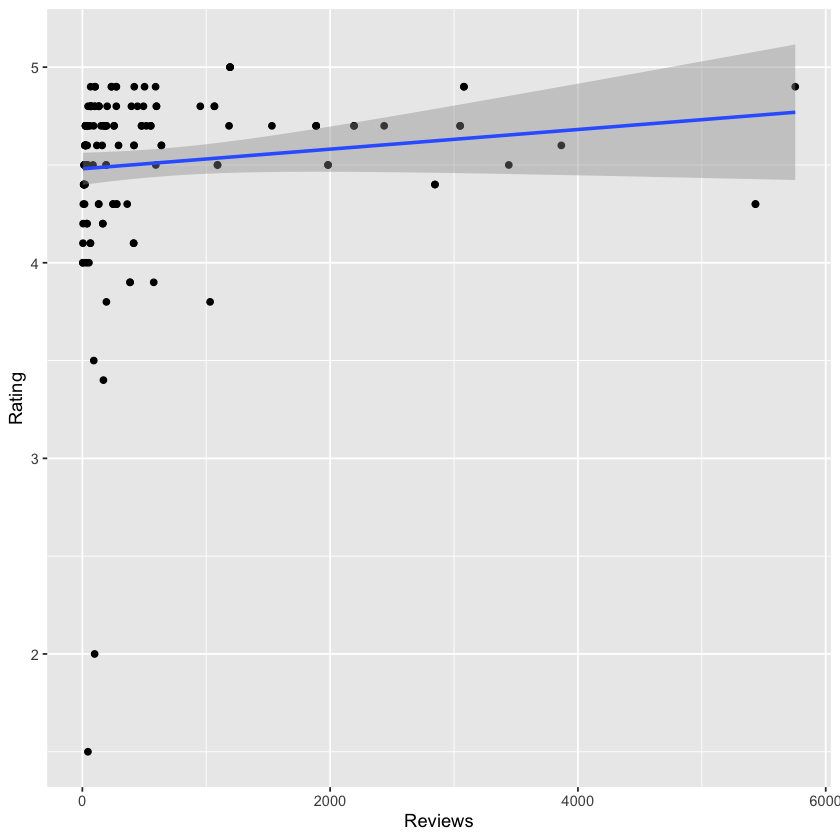

In [176]:
table1 %>% filter(Reviews > 2) %>%

ggplot( 
       aes(x = Reviews , y =  Rating)) + geom_point() + geom_smooth(method = "lm")

`geom_smooth()` using formula 'y ~ x'



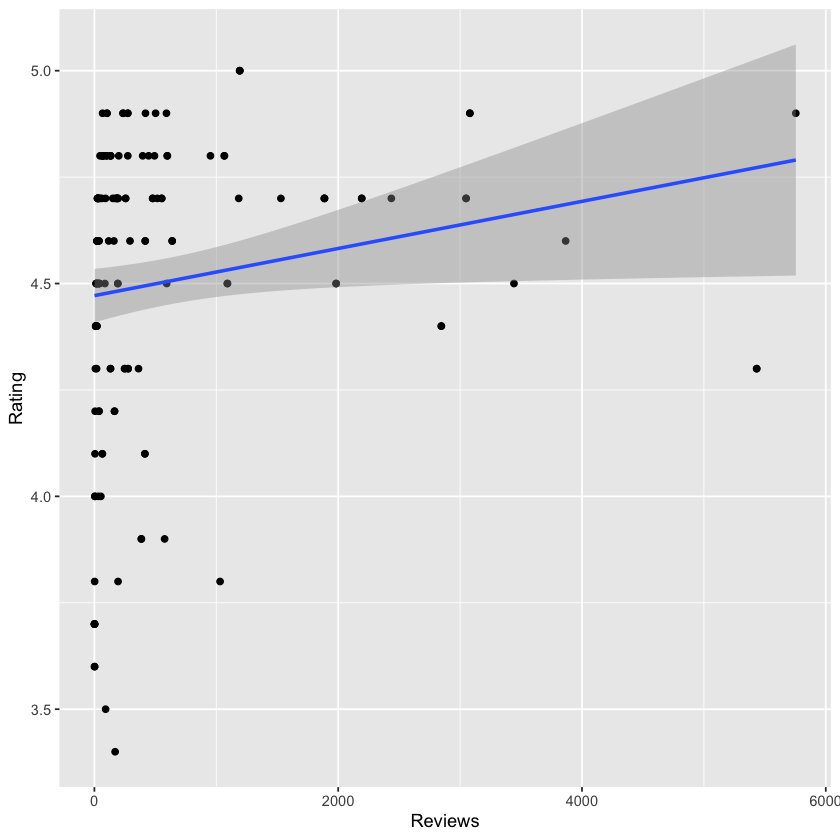

In [177]:
table <- table1 %>% filter(Reviews != 0, Rating > 2.3)
ggplot(table, 
       aes(x = Reviews , y =  Rating)) + geom_point() + geom_smooth(method = "lm")

>By removing the extreme outliers, we get a closer look into the trends between this relationship.
>There appears to be a very slight upwards trend between reviews and ratings, as we expected it to be.
>More reviews of a company would typically indicate trust of consumers to consume the company's services/products
>therefore would typically garner high ratings.
>
>However this is not a given, as we can see there is a big group of low reviewed companies that have a big range of rating values, from as low as below 3
to as high as an Excellent tier rating (> 4.5).
>
>As these variables "ratings" and "reviews" are quite independent of each other, we can expect to see little relationship and a lot of variation 
>in the plotting results.
>
>Thus, it is hard to concretely conclude that there is a relationship between the two variables, but from our plots it does have an overall postive upwards relationship.

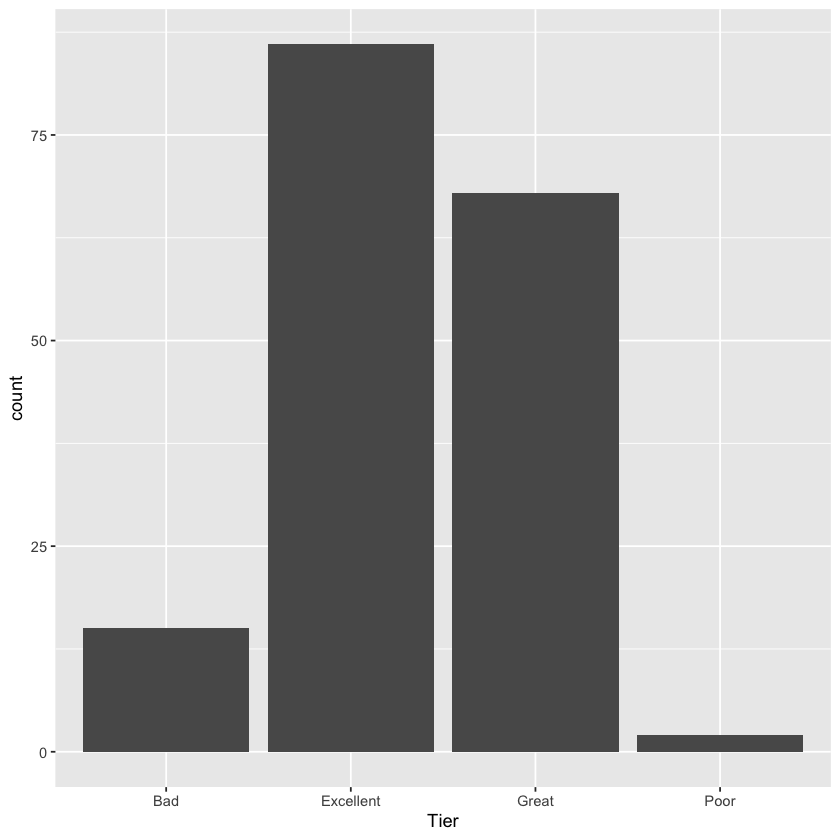

In [189]:
ggplot(data = na.omit(table1), 
       aes(x = Tier)) +
  geom_bar()

>From the total count chart it is obvious that Excellent accounts for the highest tier in the dataset, with over 75 companies recorded in this tier. This is followed by Great, Bad and then Poor. We can assume that the reason for this spread is that (1) consumers often tend to leave good reviews rather than bad by habit or (2) most companies listed are

### Task (e): APIs (2 marks)

Identify a web service offering data through an API. Access the API using `httr` and collect the information you care about. Convert the data into a dataframe (or more than one). Represent it graphically in a meaningful way.

>**New Zealand Department of Conservation Campsites API**
>
>Using the campsites API from the Department of Conservation to see the number of campsites available in each region.

In [35]:
library("httr")
library("jsonlite")


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




>Fetching data from the NZ Department of Conservation server through API and personal key:

In [36]:
library(httr)
r <- GET("https://api.doc.govt.nz/v2/campsites", add_headers("x-api-key" = "BT7AV9SXRRSfp5DMxA2y2FQZ8xABmVdaSpeAJJU0"))
r

Response [https://api.doc.govt.nz/v2/campsites]
  Date: 2021-10-12 01:25
  Status: 200
  Content-Type: application/json
  Size: 37.9 kB


>Checking the content of the fetched data:

In [37]:
str(head(content(r)))

List of 6
 $ :List of 6
  ..$ assetId: int 100030520
  ..$ name   : chr "Rarangi Campsite"
  ..$ status : chr "OPEN"
  ..$ region : chr "Marlborough"
  ..$ y      : int 5417097
  ..$ x      : int 1687530
 $ :List of 6
  ..$ assetId: int 100030548
  ..$ name   : chr "Perry Saddle Campsite"
  ..$ status : chr "OPEN"
  ..$ region : chr "Nelson/Tasman"
  ..$ y      : int 5472086
  ..$ x      : int 1549710
 $ :List of 6
  ..$ assetId: int 100031409
  ..$ name   : chr "Mill Flat Campsite"
  ..$ status : chr "OPEN"
  ..$ region : chr "Marlborough"
  ..$ y      : int 5405488
  ..$ x      : int 1642638
 $ :List of 6
  ..$ assetId: int 100038655
  ..$ name   : chr "Saxon Campsite"
  ..$ status : chr "OPEN"
  ..$ region : chr "Nelson/Tasman"
  ..$ y      : int 5473616
  ..$ x      : int 1541742
 $ :List of 6
  ..$ assetId: int 100042230
  ..$ name   : chr "Aorere Shelter Campsite"
  ..$ status : chr "OPEN"
  ..$ region : chr "Nelson/Tasman"
  ..$ y      : int 5472785
  ..$ x      : int 1552807
 $

In [38]:
http_status(r)

$category
[1] "Success"

$reason
[1] "OK"

$message
[1] "Success: (200) OK"

>Converting the content into a dataframe:

In [39]:
campsite_df <- fromJSON(rawToChar(r$content))
campsite_df

,assetId,name,status,region,y,x
,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,100030520,Rarangi Campsite,OPEN,Marlborough,5417097,1687530
2,100030548,Perry Saddle Campsite,OPEN,Nelson/Tasman,5472086,1549710
3,100031409,Mill Flat Campsite,OPEN,Marlborough,5405488,1642638
4,100038655,Saxon Campsite,OPEN,Nelson/Tasman,5473616,1541742
5,100042230,Aorere Shelter Campsite,OPEN,Nelson/Tasman,5472785,1552807
6,100042231,Gouland Downs Campsite,OPEN,Nelson/Tasman,5473166,1545509
7,100042738,John Coull Campsite,OPEN,Manawatu/Whanganui,5655602,1765211
8,100042930,Lake Tennyson Campsite,OPEN,Marlborough,5326704,1578547
9,100042949,Bettjemann Campsite,OPEN,NA,5658806,1772624


>Count of Campsites per Region:

In [181]:
df = campsite_df
campsites_by_region <- table(df$region)

 'table' int [1:18(1d)] 9 8 25 12 18 14 15 7 14 49 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:18] "Auckland" "Bay of Plenty" "Canterbury" "Central North Island" ...


>Plotting the campsites per region:

Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“conversion failure on 'Hawke’s Bay' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“conversion failure on 'Hawke’s Bay' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“conversion failure on 'Hawke’s Bay' in 'mbcsToSbcs': dot substituted for <99>”


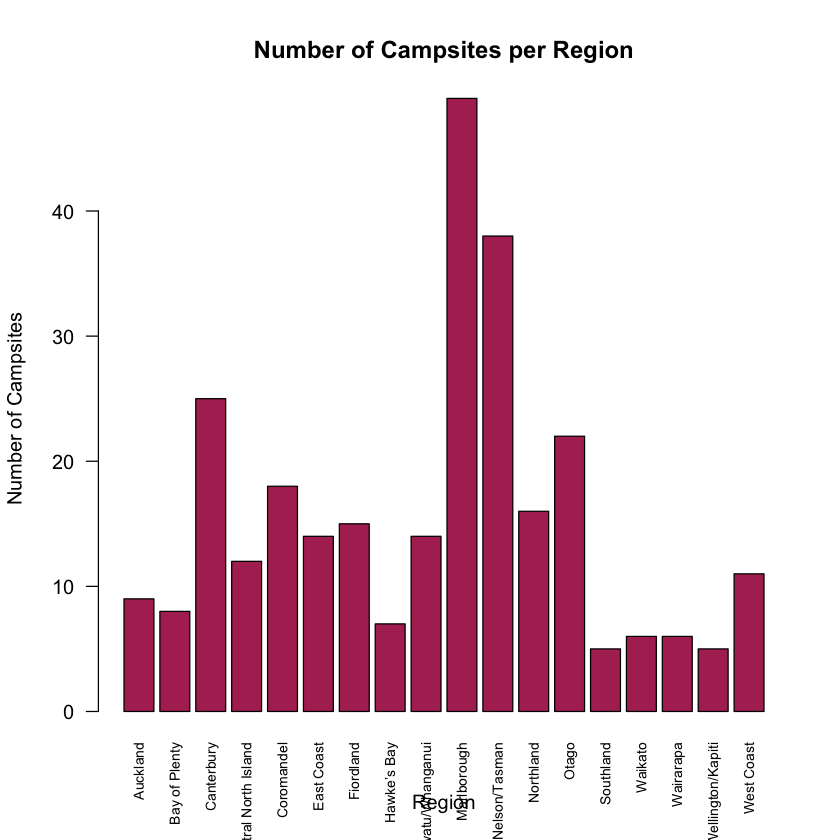

In [42]:
barplot(campsites_by_region, 
        main = "Number of Campsites per Region",
        xlab = "Region",
        ylab = "Number of Campsites", 
        col = "maroon", las=2, cex.names = 0.7)

>The barplot show that Malborough is the region with the most campsites under the New Zealand Department of Conservation, followed by Nelson/Tasman and Bay of Plenty.
>This should be largely influenced by land area of these regions and geographical features of these areas. Compared to the regions containing the 
>major cities Auckland, Wellington and Christchurch which have low campsite numbers, 
>the fact that most of the land area of these major city regions are non-rural is also another fact to consider.

>According to Google:
>- Malborough Land Area: 12,484 km²
>- Nelson/Tasman Land Area: 422.2 km² + 9,771 km² = 10,193.2 km²
>- Bay of Plenty Land Area: 12,231 km² 1,086
>
>As compared to:
>- Auckland Land Area: 1,086 km²
>- Bay of Plenty Land Area: 444 km²
>- Canterbuy Land Area: 45,346 km²
>
>These numbers show that land area is a factor but not the sole factor. Demographic and location may play a big factor into these numbers.